### MD Muhaimin Rahman
contact: sezan92@gmail.com


# Introduction

In this notebook, I am describing the implementation of Control Systems namely [PID](#pid_sec),[Fuzzy Logic](#fuzzy_sec) and [LQR](#lqr_sec) on our robot. The $pidcontrol.py$ file has been used for our project. I haven't written this library. I have downloaded from this github project.[1](#pid)

#### Importing Libraris

In [1]:
import sys
import pidcontrol as pid
import numpy as np
import pybullet as p
import math
import time
import pybullet_data
import control 
import scipy


# LQR Controller

Here, I am working on LQR controller. I have used control library [[3](#PythonControl)] of python to work on lqr. For the lqr controllers, the state-space equations of the system are required. For the Inverted pendulum , the equation will be the following
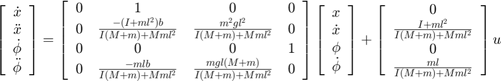

![system](LQR.png)

The above equation is derived from [[4](#SystemEquation)] .Here, $m$ mass of the pendulum, $I$ is mass moment of Inertia , $M$ mass of Cart, $g$ gravitational acceleration, $\phi$ yaw angle, $u$ is force and $x$ is the movement of the cart. we can simplify by writing , $\dot{x} = Ax+Bu $, where A and B in our robot will be the following

In [2]:
#(M)       mass of the cart                         0.5 kg
#(m)       mass of the pendulum                     0.2 kg
#(b)       coefficient of friction for cart         0.1 N/m/sec
#(l)       length to pendulum center of mass        0.3 m
#(I)       mass moment of inertia of the pendulum   0.006 kg.m^2
#(F)       force applied to the cart
#(x)       cart position coordinate
#(theta)   pendulum angle from vertical (down)
#x(t+1)=A*x(t)+B*u
#x(t+1)=k*x(t)

M = 2;
m = 5;
b = 0.5;
I = 0.10500391309238813;
g = 9.8;
l = 0.1;

px = I*(M+m)+pow(M*m*l,2) #denominator for the A and B matrices

A = np.array([[0,1],[m*g*l*(M+m)/px,0]])#considering theta and theta dot
B = np.array([[  0.  ],
       [ m*l/px]])

From [[4](#SystemEquation)] , we get the cost function \begin{equation}
J = \int (x^TQx +u^TRu)dt
\end{equation}


Here, we need to tune Q matrix and R such that the value of $J$ is minimum.

Our topics for LQR

Here, we will tune the values of Q and R using /Q and /R topic respectively.

The class for LQR

In [3]:
# Q = np.array([[ 100,   0],[  0, 1000]])
# R = 0.0001
# K,S,e = lqr(A,B,Q,R)
# print(K)
# print(S)
# print(e)

In [4]:
class SelfBalanceLQR:
    def __init__(self):
        self.xvelMin=-.01# x velocity
        self.xvelMax =0
        self.yMin = -0.01#yaw
        self.yMax = 0
        self.y_ = 0
        self.Q = np.array([[ 10,   0],[  0, 1000]])
        self.R = 0.0001
        self.K,self.S,self.e = control.lqr(A,B,self.Q,self.R)
    def callback(self,data):
        
        vel = data[0][0]
        y = data[1][1]#theata changes along 1
        
        diff_yaw = y-self.y_
        np_x = np.array([[y],[diff_yaw]])
        
        u_t=-np.matmul(self.K,np_x) 
        #print(np_x,self.K,u_t)
        #print(np_x.shape,self.K.shape,u_t.shape,A.shape,B.shape)
        xvel = (np.matmul(A,np_x)+np.matmul(B,u_t))[1]
        #print(xvel)
        
        if y>self.yMax:
            self.yMax = y
        elif y<self.yMin:
            self.yMin =y
        if xvel>self.xvelMax:
            self.xvelMax=xvel
        elif xvel<self.xvelMin:
            self.xvelMin = xvel
            
        linear_vel = [xvel,0,0]
        angular_vel=[0,0,0]
        #print("Max vel " + str(self.xvelMax) + " & Min vel " + str(self.xvelMin) + " Max y " + str(self.yMax*180/3.1416) +" & Min y" + str(self.yMin*180/3.1416))
        #print("Velocity "+ str(xvel)+ " & yaw " + str(y))
        self.y_ = y
        
        return xvel-np_x[1]
        
    def callback_q(self,data):
        q = data.data
        self.Q = np.array([[ q,   0],[  0, 10*q]])
        self.K,self.S,self.e = control.lqr(A,B,self.Q,self.R)
        
    def callback_r(self,data):
        r = data.data
        self.R = r
        self.K,self.S,self.e = control.lqr(A,B,self.Q,self.R)


In [5]:
balance=SelfBalanceLQR()
balance.callback([(0.0, 0.0, 0.0), [ 0., -0.,  0.]])

array([0.])

## Video

[Youtube Link](https://youtu.be/QmrRNw043dY)

In [ ]:
id = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
plane = p.loadURDF("plane.urdf")
p.setGravity(0, 0, -9.8)

robot = p.loadURDF("../urdf/self_balance.urdf" , [0,0,0.2])

# num = p.getNumJoints(robot)
# for i in range(num):
#     info = p.getJointInfo(robot, i)
#     print(info,end="\n")
#     link_name = info[12].decode("ascii")
#     if link_name == "left_wheel": left_wheel = j
#     if link_name == "right_wheel": wheel_foot = j
left_joint=0
right_joint=1

print("----------------------------------------------------------------------------------------------------------------")
# print("Dynamic Info of Base : ",p.getDynamicsInfo(robot, -1),end="\n")
# #0->mass , 3->local inertial pos
# print("Base position and Orientation : " , p.getBasePositionAndOrientation(robot),end="\n")
# #1->orientation

# com = p.getDynamicsInfo(robot, -1)
# com += p.getBasePositionAndOrientation(robot)[0][2] 
# print("Centre of mass - ", com)

#information required yaw
#imu sensor , kp ,ki ,kd
#set cmd_vel 
p.changeDynamics(robot,left_joint,lateralFriction=0.7,spinningFriction=0.5,rollingFriction=0.5)
p.changeDynamics(robot,right_joint,lateralFriction=0.7,spinningFriction=0.5,rollingFriction=0.5)
balance=SelfBalanceLQR()
while(True):
    position,orientation=p.getBasePositionAndOrientation(robot)
    euler_angles=np.array(p.getEulerFromQuaternion(orientation))#1->orientation
    deg_orien=euler_angles*180/np.pi
    #print(deg_orien)
    theta=deg_orien[1]
    #pos=position[0]
    velocity,angular=p.getBaseVelocity(robot)
    #print([velocity,euler_angles])
    vel=balance.callback([velocity,euler_angles])
    print(vel,theta)
    p.setJointMotorControl2(robot, left_joint , p.VELOCITY_CONTROL, targetVelocity = -vel)
    p.setJointMotorControl2(robot, right_joint , p.VELOCITY_CONTROL, targetVelocity = vel)
    p.stepSimulation()
    time.sleep(0.01)

----------------------------------------------------------------------------------------------------------------
[0.] -0.0
[-1.22311298e-24] 6.968348298364475e-26
[-1.81339443e-18] 1.0331320084333344e-19
[3.20028857e-19] 7.550087504546642e-20
[-3.84370655e-18] 2.874847276436296e-19
[-6.6850588e-18] 6.416908808438078e-19
[-8.32819327e-18] 1.0566668320264774e-18
[-0.00528771] 0.0003012529344500887
[-0.00553621] 0.0005887300164255908
[0.0118822] -0.00014281435396089817
[-0.03874204] 0.0020776487718024953
[0.10991493] -0.004377097395902839
[-0.32663805] 0.014638062821573187
[0.95530699] -0.04114520653067197
[-3.61670506] 0.16872170117636637
[5.28398349] -0.14796313302782654
[-3.73062868] 0.07829879471326061
[5.91634696] -0.2660288691126562
[-3.09686616] -0.06492633677059939
[5.81257083] -0.3900613008954422
[-4.11042384] -0.1197133940191848
[6.90431743] -0.5019675542368354
[-2.1299405] -0.3340758692778649
[6.02051971] -0.6461016484117291
[-3.58146914] -0.3821485062261458
[5.98373571] -0.687

[-4.05270906] -0.7495343332433807
[5.48012174] -0.9922496507772318
[-4.64399996] -0.6356656817543785
[5.7649148] -0.9051646017901819
[-4.44952871] -0.5677349291189665
[5.82096749] -0.8467260763938664
[-4.47670033] -0.5131670028487929
[5.61340502] -0.785392583144635
[-4.5368897] -0.454091445545746
[5.68108982] -0.735650875061517
[-4.55271141] -0.40806056628671
[5.50193536] -0.6836813114168302
[-4.69636246] -0.35272568304131297
[5.56286466] -0.6369485529886864
[-4.56080612] -0.3180490991205334
[5.95104512] -0.6276028144996609
[-4.24375564] -0.32763300620459335
[5.98050009] -0.637976182880953
[-5.16241247] -0.2847065842590905
[5.88160376] -0.593395705562423
[-4.38377747] -0.2886203444148983
[6.19592353] -0.6148540687107236
[-3.89096451] -0.33616566909421164
[6.51595191] -0.6762235555389655
[-3.75355414] -0.3996733356293425
[6.68553649] -0.7435041790963747
[-5.10994773] -0.38343868432991923
[5.81516027] -0.6791875813737063
[-5.15457087] -0.32254346934438594
[5.91232979] -0.6294747514117107

[5.64364289] -0.6207185453022229
[-4.83555769] -0.28767078392635465
[5.86311702] -0.5950318231886157
[-4.28376499] -0.29580269022379585
[6.0232643] -0.6115336593190347
[-4.2241234] -0.3141723322967824
[6.07493142] -0.6311435944104459
[-4.24364419] -0.33085182163777116
[6.60493425] -0.6764719492877566
[-3.19582071] -0.4316740189440952
[5.51877827] -0.706064819359721
[-4.41822492] -0.3888798308570263
[6.26032999] -0.7094865207758204
[-3.80343418] -0.4270102634799118
[6.01066603] -0.7298574500783821
[-3.72435019] -0.4499979199853051
[6.37631415] -0.7715454013697463
[-4.39353011] -0.44969573956170106
[5.02746595] -0.694424340467108
[-5.38284897] -0.32336190821238064
[5.4514088] -0.6039576020862496
[-4.4996541] -0.2916011534704718
[5.82018291] -0.5961517031528719
[-4.24161005] -0.29922039237526565
[6.51230909] -0.6424964357387434
[-4.36613333] -0.33417350726087247
[5.86849745] -0.6375291849182289
[-5.00376716] -0.2933394113377838
[5.35979898] -0.5714996806709187
[-4.66186256] -0.25291146658

[-4.60459663] -0.330339235820234
[6.63936788] -0.6779686533722071
[-4.41739555] -0.36343609170103947
[5.77874199] -0.6589648693904366
[-4.49601162] -0.34171547260957397
[5.91455243] -0.646995687769536
[-3.91375982] -0.3640283034760864
[6.56587129] -0.7043466865590853
[-5.44174809] -0.3290086044495944
[4.95549613] -0.5808274620826306
[-5.18018564] -0.23184431808776618
[5.81352434] -0.5415563791115136
[-5.04030874] -0.20418368897098757
[5.7182708] -0.5110337343282216
[-5.07520967] -0.1745028274930658
[5.6126717] -0.47808877079756573
[-5.27306569] -0.13334033792250555
[5.46880851] -0.43254680510203064
[-4.3642074] -0.1438008745423135
[6.02285147] -0.4736024704494257
[-3.97019349] -0.20349756707859532
[5.99650201] -0.5262626867062711
[-4.10345985] -0.24368245858655532
[5.88570732] -0.5564092714006041
[-3.94850343] -0.27986195912159423
[6.16360557] -0.6050665657413172
[-4.18003462] -0.310816727105815
[6.32942343] -0.6425981122729035
[-5.23398294] -0.2848224223290262
[5.53859346] -0.57395873

## Conclusion

In this project , I have tested three famous controllers on Self Balancing Robot Simulation. I am planning to work on other controllers as well, like Fuzzy PID, Adaptive Fuzzy, Neural Network, Sliding motion controller etc. I also intend to work on other control system problems as well. Control System is fun! Please contact me for any confusions or bugs. 

#### MD Muhaimin Rahman


# Reference

<a id ="pid"></a>
[1] PyQuadSim [Repository](https://github.com/simondlevy/PyQuadSim/blob/master/pidcontrol.py)
<br/>
<a id ="fuzzy"></a>
[2] Scikit-fuzzy DOI link 10.5281/zenodo.1002946
<br/>
<a id ="PythonControl"></a>
[3] Python Control Package , [link](https://python-control.readthedocs.io/en/latest/)
<br/>
<a id ="SystemEquation"></a>
[4] Control System Tutorials , [link](http://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling)
https://automaticaddison.com/linear-quadratic-regulator-lqr-with-python-code-example/
